In [42]:
import geopandas as gpd
import rasterio
from rasterio.features import shapes
import pandas as pd
from shapely.geometry import shape, Point, Polygon, MultiPoint
from scipy.spatial import Voronoi
import numpy as np
from shapely.ops import unary_union

import os
from os.path import join
from pathlib import Path

In [22]:
def raster_to_polygons(raster_path, output_path_1, classification_column='clase'):
    """
    Convierte un raster a polígonos y los agrupa por clasificación
    """
    with rasterio.open(raster_path) as src:
        # Leer el raster
        raster_data = src.read(1)
        transform = src.transform
        
        # Convertir raster a polígonos
        polygons = []
        values = []
        
        for geom, value in shapes(raster_data, transform=transform):
            if value != src.nodata:
                polygons.append(shape(geom))
                values.append(value)
    
    # Crear GeoDataFrame
    gdf_polygons = gpd.GeoDataFrame({
        classification_column: values,
        'geometry': polygons
    }, crs=src.crs)
    
    # Dissolve por clasificación (combinar polígonos con misma clasificación)
    dissolved = gdf_polygons.dissolve(by=classification_column).reset_index()
    
    # Explode para separar multipolígonos en polígonos individuales
    exploded = dissolved.explode(index_parts=True).reset_index(drop=True)

    exploded.to_file(output_path_1, driver='GPKG')

    return print("procesos terminado")

PROJECT_DIR = Path("C:/Users/PREDATOR/Desktop/Anzony_Apoyo/04_CentrosPoblados")
DATA_RAW_1  = PROJECT_DIR / "Raster_Prueba.tif"
DATA_PRO_1  = PROJECT_DIR / "Exploded.gpkg"

raster_to_polygons(DATA_RAW_1, DATA_PRO_1, )

procesos terminado


In [ ]:
def point_polygon_intersection(point_path, polygon_path, output_path):
    point = gpd.read_file(point_path)
    polygon = gpd.read_file(polygon_path)

    intersect = gpd.overlay(df1=point, df2=polygon, how="intersection", keep_geom_type=False)

    intersect.to_file(output_path, driver="GPKG")

    return print("terminado")

DATA_RAW_1  = PROJECT_DIR / "CCPP_LimaCallao.gpkg"
DATA_RAW_2  = PROJECT_DIR / "Exploded.gpkg"
DATA_PRO_1  = PROJECT_DIR / "CCPP_exploded.gpkg"

point_polygon_intersection(DATA_RAW_1, DATA_RAW_2, DATA_PRO_1)

terminado


In [29]:
from scipy.spatial import Voronoi

In [ ]:
puntos = gpd.read_file(DATA_PRO_1)
puntos['longitude'] = puntos['geometry'].apply(lambda p: p.x)
puntos['latitude'] = puntos['geometry'].apply(lambda p: p.y)
var = Voronoi(puntos[['longitude','latitude']].values)

# Crear el convex hull de los puntos para usar como máscara de recorte
points_multipoint = MultiPoint([Point(x, y) for x, y in puntos[['longitude','latitude']].values])
convex_hull = points_multipoint.convex_hull

# Crear polígonos de Voronoi finitos y recortarlos
voronoi_polygons_clipped = []
for region in var.regions:
    if region and -1 not in region:  # Solo regiones finitas
        polygon = Polygon(var.vertices[region])
        # Recortar el polígono con el convex hull
        clipped_polygon = polygon.intersection(convex_hull)
        if not clipped_polygon.is_empty:
            voronoi_polygons_clipped.append(clipped_polygon)

gdf_voronoi_clipped = gpd.GeoDataFrame(geometry=voronoi_polygons_clipped, crs="EPSG:4326")
gdf_voronoi_clipped.to_file("voronoi_clipped.gpkg", driver="GPKG")

# Ejemplos:
# https://stackoverflow.com/questions/34968838/python-finite-boundary-voronoi-cells
# https://www.youtube.com/watch?v=_NS09YUNrFw
# https://medium.com/analytics-vidhya/create-voronoi-regions-with-python-28720b9c70d8

Se crearon 5214 polígonos de Voronoi recortados


In [60]:
# 1. Cargar puntos y límite (ambos deben estar en el mismo CRS)
gdf_puntos = gpd.read_file(DATA_PRO_1)       # puntos como GeoDataFrame
gdf_limite = gpd.read_file(DATA_RAW_2)       # polígono límite

# Asegurarse de que estén en el mismo sistema de referencia (idealmente proyectado, como EPSG:32718)
gdf_puntos = gdf_puntos.to_crs(epsg=4326)
gdf_limite = gdf_limite.to_crs(epsg=4326)

gdf_puntos = gdf_puntos[gdf_puntos['clase']==30]
gdf_limite = gdf_limite[gdf_limite['clase']==30]

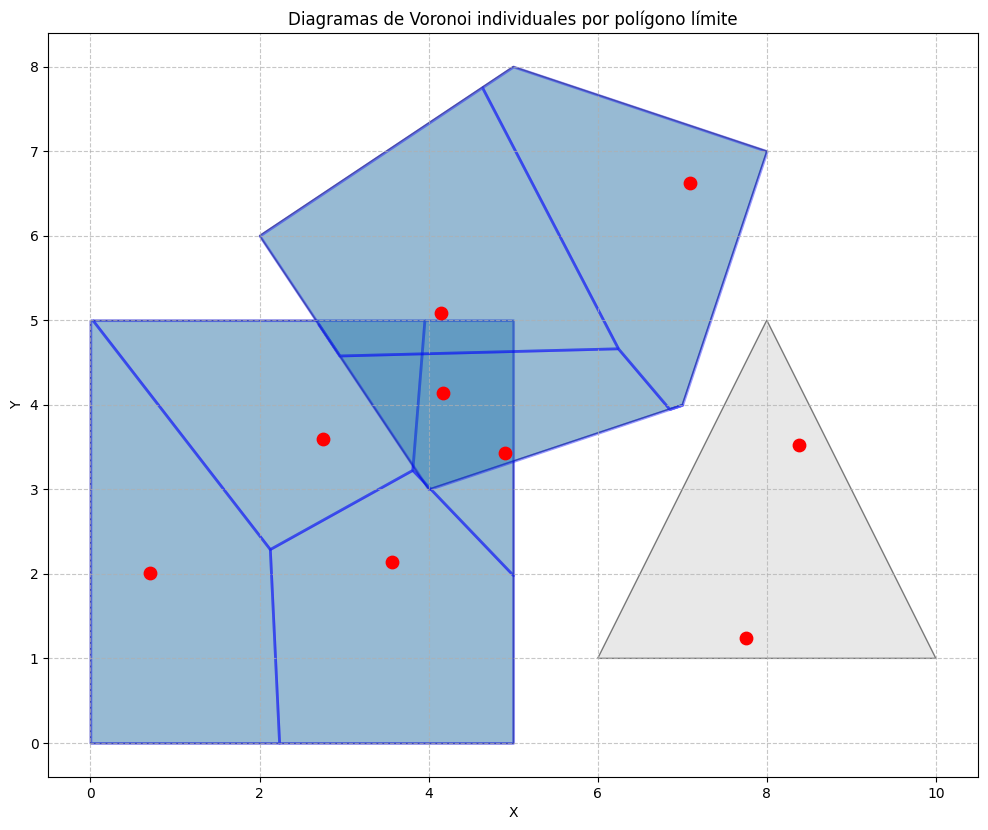

In [63]:
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon, Point, MultiPoint
from geovoronoi import voronoi_regions_from_coords
import matplotlib.pyplot as plt

# 1. Crear datos de ejemplo
# Tres polígonos límite (cuadrado, triángulo, pentágono)
boundaries = gpd.GeoSeries([
    Polygon([(0, 0), (5, 0), (5, 5), (0, 5)]),            # Cuadrado
    Polygon([(6, 1), (10, 1), (8, 5)]),                   # Triángulo
    Polygon([(2, 6), (5, 8), (8, 7), (7, 4), (4, 3)])     # Pentágono
])

# Puntos aleatorios distribuidos en cada polígono
np.random.seed(123)
points = []
for boundary in boundaries:
    minx, miny, maxx, maxy = boundary.bounds
    # Generar puntos hasta tener 2-4 dentro del polígono
    pts = []
    while len(pts) < np.random.randint(2, 5):
        x = np.random.uniform(minx, maxx)
        y = np.random.uniform(miny, maxy)
        p = Point(x, y)
        if boundary.contains(p):
            pts.append([x, y])
    points.append(np.array(pts))

# 2. Procesar cada polígono individualmente
fig, ax = plt.subplots(figsize=(12, 10))

# Dibujar todos los polígonos límite primero
boundaries.plot(ax=ax, color='lightgray', edgecolor='black', alpha=0.5)

# Para cada polígono límite
for i, boundary in enumerate(boundaries):
    # Obtener puntos de este polígono
    poly_points = points[i]
    
    if len(poly_points) > 0:
        # Generar Voronoi solo para este polígono
        polygons, _ = voronoi_regions_from_coords(poly_points, boundary)
        
        # Dibujar cada celda de Voronoi
        for poly in polygons.values():
            gpd.GeoSeries([poly]).plot(
                ax=ax, 
                alpha=0.4, 
                edgecolor='blue',
                cmap='tab20',  # Usar mapa de colores para diferenciar
                linewidth=2
            )
        
        # Dibujar puntos semilla
        ax.scatter(
            poly_points[:, 0], 
            poly_points[:, 1], 
            color='red', 
            s=80,
            zorder=3
        )

# Configuración del gráfico
ax.set_title('Diagramas de Voronoi individuales por polígono límite')
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [66]:
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon
from scipy.spatial import Voronoi
import os

def bounded_voronoi(points, boundary):
    """
    Genera polígonos de Voronoi recortados a un polígono límite.
    
    Args:
        points: Array de numpy con coordenadas de puntos (shape: (n, 2))
        boundary: Polígono Shapely que define el límite.
    
    Returns:
        Lista de polígonos de Voronoi recortados (Shapely Polygon).
    """
    if len(points) == 0:
        return []
    
    # Manejar caso especial con un solo punto
    if len(points) == 1:
        return [boundary]
    
    # Añadir puntos lejanos para evitar regiones infinitas
    minx, miny, maxx, maxy = boundary.bounds
    expansion = max(maxx-minx, maxy-miny) * 2
    far_points = [
        [minx - expansion, miny - expansion],
        [minx - expansion, maxy + expansion],
        [maxx + expansion, maxy + expansion],
        [maxx + expansion, miny - expansion]
    ]
    all_points = np.vstack([points, far_points])
    
    # Calcular diagrama de Voronoi
    vor = Voronoi(all_points)
    
    # Crear polígonos de Voronoi recortados
    result = []
    for i in range(len(points)):
        region_index = vor.point_region[i]
        region = vor.regions[region_index]
        
        if -1 in region or len(region) == 0:
            continue
            
        poly = Polygon(vor.vertices[region])
        
        # Recortar con el límite
        clipped = poly.intersection(boundary)
        
        # Manejar diferentes tipos de geometrías resultantes
        if clipped.is_empty:
            continue
            
        if clipped.geom_type == 'GeometryCollection':
            # Filtrar solo polígonos
            for geom in clipped.geoms:
                if geom.geom_type == 'Polygon':
                    result.append(geom)
        elif clipped.geom_type == 'Polygon':
            result.append(clipped)
    
    return result

# 1. Cargar datos
gdf_puntos = gpd.read_file(DATA_PRO_1)
gdf_limite = gpd.read_file(DATA_RAW_2)

# 2. Filtrar por clase 30
gdf_puntos = gdf_puntos[gdf_puntos['clase'] == 30]
gdf_limite = gdf_limite[gdf_limite['clase'] == 30]

# 3. Convertir a EPSG:4326 (WGS84)
crs_proyectado = 'EPSG:4326'

gdf_puntos = gdf_puntos.to_crs(crs_proyectado)
gdf_limite = gdf_limite.to_crs(crs_proyectado)

# Directorio de salida
output_dir = "resultados_voronoi"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 4. Procesar cada polígono límite y recolectar resultados
all_voronoi = []
all_attributes = []

for idx, limite in gdf_limite.iterrows():
    boundary = limite.geometry
    
    # Encontrar puntos dentro de este polígono límite
    puntos_en_limite = gdf_puntos[gdf_puntos.within(boundary)]
    
    if len(puntos_en_limite) == 0:
        continue
        
    # Obtener coordenadas de los puntos
    points_coords = np.array([
        [punto.x, punto.y] 
        for punto in puntos_en_limite.geometry
    ])
    
    # Generar Voronoi recortado
    voronoi_polys = bounded_voronoi(points_coords, boundary)
    
    # Recolectar resultados con atributos
    for poly in voronoi_polys:
        all_voronoi.append(poly)
        
        # Crear registro de atributos
        attrs = {
            'limite_id': idx,
            'num_puntos': len(puntos_en_limite),
            'area': poly.area,
            'perimetro': poly.length
        }
        
        # Copiar atributos del polígono límite
        for field in gdf_limite.columns:
            if field != 'geometry':
                attrs[f'lim_{field}'] = limite[field]
        
        all_attributes.append(attrs)

# 5. Crear GeoDataFrame con los resultados
if len(all_voronoi) > 0:
    gdf_voronoi = gpd.GeoDataFrame(
        all_attributes,
        geometry=all_voronoi,
        crs=gdf_limite.crs
    )
    
    # 6. Guardar como shapefile
    output_path = os.path.join(output_dir, "voronoi_clase30.shp")
    gdf_voronoi.to_file(output_path, encoding='utf-8')
    print(f"Shapefile guardado en: {output_path}")
    print(f"Total de polígonos generados: {len(gdf_voronoi)}")
else:
    print("No se generaron polígonos de Voronoi. Verifique los datos de entrada.")

Shapefile guardado en: resultados_voronoi\voronoi_clase30.shp
Total de polígonos generados: 44


In [73]:
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon, Point
from scipy.spatial import Voronoi
import os
import warnings
from tqdm import tqdm

# Suprimir advertencias de Shapely
warnings.filterwarnings("ignore", category=UserWarning, module="shapely")

def bounded_voronoi(points, boundary):
    """
    Genera polígonos de Voronoi recortados a un polígono límite.
    Versión mejorada para manejar todos los puntos.
    """
    if len(points) == 0:
        return []
    
    # Caso especial con un solo punto
    if len(points) == 1:
        return [boundary]
    
    # Verificar si hay puntos duplicados
    unique_points = np.unique(points, axis=0)
    if len(unique_points) < len(points):
        print(f"Advertencia: {len(points) - len(unique_points)} puntos duplicados encontrados")
        points = unique_points
    
    # Calcular la caja delimitadora expandida
    minx, miny, maxx, maxy = boundary.bounds
    expansion = max(maxx-minx, maxy-miny) * 3
    far_points = [
        [minx - expansion, miny - expansion],
        [minx - expansion, maxy + expansion],
        [maxx + expansion, maxy + expansion],
        [maxx + expansion, miny - expansion]
    ]
    all_points = np.vstack([points, far_points])
    
    # Calcular diagrama de Voronoi
    vor = Voronoi(all_points)
    
    # Crear polígonos de Voronoi recortados
    result = []
    processed_indices = set()
    
    for i in range(len(points)):
        if i in processed_indices:
            continue
            
        region_index = vor.point_region[i]
        region = vor.regions[region_index]
        
        # Saltar regiones no válidas
        if -1 in region or len(region) == 0:
            continue
            
        try:
            poly = Polygon(vor.vertices[region])
            if not poly.is_valid:
                poly = poly.buffer(0)  # Intentar reparar geometría
            
            # Recortar con el límite
            clipped = poly.intersection(boundary)
            
            # Manejar diferentes tipos de geometrías
            if clipped.is_empty:
                continue
                
            if clipped.geom_type in ['MultiPolygon', 'GeometryCollection']:
                for geom in clipped.geoms:
                    if geom.geom_type == 'Polygon':
                        result.append(geom)
                        processed_indices.add(i)
            elif clipped.geom_type == 'Polygon':
                result.append(clipped)
                processed_indices.add(i)
        except Exception as e:
            print(f"Error procesando punto {i}: {e}")
            continue
    
    # Manejar puntos no procesados
    unprocessed = set(range(len(points))) - processed_indices
    if unprocessed:
        print(f"{len(unprocessed)} puntos no generaron polígonos. Asignando polígono completo...")
        for i in unprocessed:
            result.append(boundary)
    
    return result

# 1. Cargar datos
gdf_puntos = gpd.read_file(DATA_PRO_1)
gdf_limite = gpd.read_file(DATA_RAW_2)

# 2. Filtrar por clase 30
gdf_puntos = gdf_puntos[gdf_puntos['clase'] == 30].copy()
gdf_limite = gdf_limite[gdf_limite['clase'] == 30].copy()

# 3. Convertir a un CRS proyectado adecuado
crs_proyectado = "EPSG:4326"  # UTM zona 18S para Perú
gdf_puntos = gdf_puntos.to_crs(crs_proyectado)
gdf_limite = gdf_limite.to_crs(crs_proyectado)

# 4. Realizar una unión espacial para asignar puntos a polígonos
print(f"Puntos iniciales: {len(gdf_puntos)}")
print(f"Polígonos límite: {len(gdf_limite)}")

# Unión espacial para encontrar qué puntos están en qué polígonos
gdf_joint = gpd.sjoin(gdf_puntos, gdf_limite, how="inner", predicate="within")
print(f"Puntos asignados a polígonos: {len(gdf_joint)}")

# Identificar puntos no asignados
puntos_no_asignados = gdf_puntos[~gdf_puntos.index.isin(gdf_joint.index)]
print(f"Puntos no asignados: {len(puntos_no_asignados)}")

# 5. Preparar directorio de salida
output_dir = "resultados_voronoi"
os.makedirs(output_dir, exist_ok=True)

# 6. Procesar cada polígono límite
print("Procesando polígonos...")
all_voronoi = []
all_attributes = []
puntos_fallidos = []

# Agrupar puntos por polígono límite
grupos = gdf_joint.groupby('index_right')

for idx, limite in tqdm(gdf_limite.iterrows(), total=len(gdf_limite)):
    # Obtener puntos para este polígono límite
    if idx in grupos.groups:
        puntos_en_limite = gdf_joint.loc[grupos.groups[idx]]
    else:
        continue
        
    print(f"\nPolígono {idx}: {len(puntos_en_limite)} puntos")
    
    # Obtener coordenadas de los puntos
    points_coords = np.array([
        [punto.geometry.x, punto.geometry.y] 
        for _, punto in puntos_en_limite.iterrows()
    ])
    
    boundary = limite.geometry
    
    # Generar Voronoi recortado
    voronoi_polys = bounded_voronoi(points_coords, boundary)
    print(f"  Polígonos Voronoi generados: {len(voronoi_polys)}")
    
    # Si faltan polígonos, registrar los puntos fallidos
    if len(voronoi_polys) < len(points_coords):
        missing = len(points_coords) - len(voronoi_polys)
        print(f"  Advertencia: {missing} puntos no generaron polígonos")
        puntos_fallidos.extend([
            (idx, punto_id) 
            for punto_id in puntos_en_limite.index[-missing:]
        ])
    
    # Recolectar resultados con atributos
    for j, poly in enumerate(voronoi_polys):
        if j < len(puntos_en_limite):
            punto_id = puntos_en_limite.index[j]
            punto_data = gdf_puntos.loc[punto_id]
        else:
            # Esto no debería ocurrir, pero por si acaso
            punto_id = None
            punto_data = None
        
        # Crear registro de atributos
        attrs = {
            'voronoi_id': f"{idx}_{punto_id or j}",
            'limite_id': idx,
            'punto_id': punto_id,
            'area_m2': poly.area,
            'perim_m': poly.length
        }
        
        # Copiar atributos del polígono límite
        for field in gdf_limite.columns:
            if field != 'geometry':
                attrs[f'lim_{field}'] = limite[field]
        
        # Copiar atributos del punto si está disponible
        if punto_data is not None:
            for field in gdf_puntos.columns:
                if field != 'geometry':
                    attrs[f'punto_{field}'] = punto_data[field]
        
        all_attributes.append(attrs)
        all_voronoi.append(poly)

# 7. Manejar puntos no asignados
if puntos_no_asignados.empty:
    print("\nTodos los puntos fueron asignados a polígonos límite")
else:
    print(f"\nAdvertencia: {len(puntos_no_asignados)} puntos no asignados a ningún polígono")
    # Intentar asignarlos al polígono más cercano
    for idx, punto in puntos_no_asignados.iterrows():
        # Encontrar el polígono más cercano
        distancias = gdf_limite.distance(punto.geometry)
        idx_limite = distancias.idxmin()
        limite = gdf_limite.loc[idx_limite]
        
        print(f"  Punto {idx} asignado al polígono {idx_limite} por proximidad")
        
        # Crear un polígono de Voronoi para este punto (el polígono completo)
        poly = limite.geometry
        
        # Crear registro de atributos
        attrs = {
            'voronoi_id': f"extra_{idx}",
            'limite_id': idx_limite,
            'punto_id': idx,
            'area_m2': poly.area,
            'perim_m': poly.length,
            'nota': "asignado_por_proximidad"
        }
        
        # Copiar atributos
        for field in gdf_limite.columns:
            if field != 'geometry':
                attrs[f'lim_{field}'] = limite[field]
        
        for field in gdf_puntos.columns:
            if field != 'geometry':
                attrs[f'punto_{field}'] = punto[field]
        
        all_attributes.append(attrs)
        all_voronoi.append(poly)

# 8. Manejar puntos fallidos
if puntos_fallidos:
    print(f"\nPuntos fallidos durante la generación Voronoi: {len(puntos_fallidos)}")
    for idx_limite, punto_id in puntos_fallidos:
        limite = gdf_limite.loc[idx_limite]
        punto = gdf_puntos.loc[punto_id]
        
        # Crear un polígono de Voronoi para este punto (el polígono completo)
        poly = limite.geometry
        
        # Crear registro de atributos
        attrs = {
            'voronoi_id': f"fallido_{idx_limite}_{punto_id}",
            'limite_id': idx_limite,
            'punto_id': punto_id,
            'area_m2': poly.area,
            'perim_m': poly.length,
            'nota': "generacion_fallida"
        }
        
        # Copiar atributos
        for field in gdf_limite.columns:
            if field != 'geometry':
                attrs[f'lim_{field}'] = limite[field]
        
        for field in gdf_puntos.columns:
            if field != 'geometry':
                attrs[f'punto_{field}'] = punto[field]
        
        all_attributes.append(attrs)
        all_voronoi.append(poly)

# 9. Crear y guardar resultados
if len(all_voronoi) > 0:
    gdf_voronoi = gpd.GeoDataFrame(
        all_attributes,
        geometry=all_voronoi,
        crs=crs_proyectado
    )
    
    # Guardar como shapefile
    output_path = os.path.join(output_dir, "voronoi_clase30.shp")
    gdf_voronoi.to_file(output_path, encoding='utf-8')
    
    print(f"\nShapefile guardado en: {output_path}")
    print(f"Total de polígonos generados: {len(gdf_voronoi)}")
    print(f"Total de puntos procesados: {len(gdf_puntos)}")
    
    # Guardar puntos no asignados si existen
    if not puntos_no_asignados.empty:
        puntos_no_asignados_path = os.path.join(output_dir, "puntos_no_asignados.shp")
        puntos_no_asignados.to_file(puntos_no_asignados_path, encoding='utf-8')
        print(f"Puntos no asignados guardados en: {puntos_no_asignados_path}")
else:
    print("No se generaron polígonos de Voronoi. Verifique los datos de entrada.")

Puntos iniciales: 53
Polígonos límite: 23
Puntos asignados a polígonos: 53
Puntos no asignados: 0
Procesando polígonos...


100%|██████████| 23/23 [00:00<00:00, 677.18it/s]


Polígono 8746: 40 puntos
  Polígonos Voronoi generados: 50

Polígono 8747: 3 puntos
  Polígonos Voronoi generados: 3

Polígono 8748: 7 puntos
  Polígonos Voronoi generados: 8

Polígono 8749: 3 puntos
  Polígonos Voronoi generados: 3

Todos los puntos fueron asignados a polígonos límite

Shapefile guardado en: resultados_voronoi\voronoi_clase30.shp
Total de polígonos generados: 64
Total de puntos procesados: 53


In [75]:
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon
from scipy.spatial import Voronoi
import os
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module="shapely")

def bounded_voronoi(points, boundary):
    """Genera polígonos de Voronoi recortados a un polígono límite."""
    if len(points) <= 1:
        return [boundary] if len(points) == 1 else []
    
    # Eliminar duplicados
    unique_points = np.unique(points, axis=0)
    
    # Expandir límites para puntos auxiliares
    minx, miny, maxx, maxy = boundary.bounds
    exp = max(maxx-minx, maxy-miny) * 3
    far_points = np.array([
        [minx-exp, miny-exp], [minx-exp, maxy+exp],
        [maxx+exp, maxy+exp], [maxx+exp, miny-exp]
    ])
    
    # Generar Voronoi
    vor = Voronoi(np.vstack([unique_points, far_points]))
    
    result = []
    for i in range(len(unique_points)):
        region = vor.regions[vor.point_region[i]]
        if -1 not in region and len(region) > 0:
            try:
                poly = Polygon(vor.vertices[region])
                if not poly.is_valid:
                    poly = poly.buffer(0)
                
                clipped = poly.intersection(boundary)
                if not clipped.is_empty and clipped.geom_type == 'Polygon':
                    result.append(clipped)
                elif clipped.geom_type == 'MultiPolygon':
                    result.extend([g for g in clipped.geoms if g.geom_type == 'Polygon'])
            except:
                continue
    
    # Completar con polígono límite si faltan
    while len(result) < len(unique_points):
        result.append(boundary)
    
    return result[:len(unique_points)]

def process_voronoi(points_file, boundary_file, output_dir="resultados_voronoi", clase_valor=0):
    """Procesa archivos y genera polígonos de Voronoi."""
    
    # Cargar y filtrar datos
    gdf_points = gpd.read_file(points_file)
    gdf_boundary = gpd.read_file(boundary_file)
    
    gdf_points = gdf_points[gdf_points['clase'] == clase_valor].to_crs("EPSG:4326")
    gdf_boundary = gdf_boundary[gdf_boundary['clase'] == clase_valor].to_crs("EPSG:4326")
    
    print(f"Puntos: {len(gdf_points)}, Límites: {len(gdf_boundary)}")
    
    # Unión espacial
    gdf_joint = gpd.sjoin(gdf_points, gdf_boundary, how="inner", predicate="within")
    unassigned = gdf_points[~gdf_points.index.isin(gdf_joint.index)]
    
    print(f"Asignados: {len(gdf_joint)}, No asignados: {len(unassigned)}")
    
    # Procesar polígonos
    os.makedirs(output_dir, exist_ok=True)
    all_voronoi, all_attrs = [], []
    
    for idx, boundary in gdf_boundary.iterrows():
        # Obtener puntos en este límite
        mask = gdf_joint['index_right'] == idx
        if not mask.any():
            continue
            
        points_in_boundary = gdf_joint[mask]
        coords = np.array([[p.geometry.x, p.geometry.y] for _, p in points_in_boundary.iterrows()])
        
        # Generar Voronoi
        voronoi_polys = bounded_voronoi(coords, boundary.geometry)
        
        # Recolectar resultados
        for j, poly in enumerate(voronoi_polys):
            if j < len(points_in_boundary):
                point_id = points_in_boundary.index[j]
                point_data = gdf_points.loc[point_id]
            else:
                point_id, point_data = None, None
            
            attrs = {
                'voronoi_id': f"{idx}_{point_id or j}",
                'limite_id': idx,
                'punto_id': point_id,
                'area_m2': poly.area,
                'perim_m': poly.length
            }
            
            # Copiar atributos relevantes
            for field in ['clase', 'nombre', 'codigo']:  # Ajustar según campos necesarios
                if field in gdf_boundary.columns:
                    attrs[f'lim_{field}'] = boundary.get(field)
                if point_data is not None and field in gdf_points.columns:
                    attrs[f'punto_{field}'] = point_data.get(field)
            
            all_attrs.append(attrs)
            all_voronoi.append(poly)
    
    # Manejar puntos no asignados (asignar al límite más cercano)
    for idx, point in unassigned.iterrows():
        nearest_idx = gdf_boundary.distance(point.geometry).idxmin()
        nearest_boundary = gdf_boundary.loc[nearest_idx]
        
        attrs = {
            'voronoi_id': f"extra_{idx}",
            'limite_id': nearest_idx,
            'punto_id': idx,
            'area_m2': nearest_boundary.geometry.area,
            'perim_m': nearest_boundary.geometry.length,
            'nota': "asignado_por_proximidad"
        }
        
        all_attrs.append(attrs)
        all_voronoi.append(nearest_boundary.geometry)
    
    # Guardar resultados
    if all_voronoi:
        gdf_result = gpd.GeoDataFrame(all_attrs, geometry=all_voronoi, crs="EPSG:4326")
        output_path = os.path.join(output_dir, "voronoi_clase30.shp")
        gdf_result.to_file(output_path, encoding='utf-8')
        
        print(f"Shapefile guardado: {output_path}")
        print(f"Total polígonos: {len(gdf_result)}")
        return gdf_result
    else:
        print("No se generaron polígonos de Voronoi")
        return None

# Uso del código optimizado
if __name__ == "__main__":
    # Ejecutar procesamiento
    result = process_voronoi(DATA_PRO_1, DATA_RAW_2, clase_valor=30)

Puntos: 53, Límites: 23
Asignados: 53, No asignados: 0
Shapefile guardado: resultados_voronoi\voronoi_clase30.shp
Total polígonos: 53
